# Blog Post: Spectral Clustering

In this blog post, you'll write a tutorial on a simple version of the *spectral clustering* algorithm for clustering data points. Each of the below parts will pose to you one or more specific tasks. You should plan to both:

- Achieve these tasks using clean, efficient, and well-documented Python and 
- Write, in your own words, about how to understand what's going on.  

> Remember, your aim is not just to write and understand the algorithm, but to explain to someone else how they could do the same. 

***Note***: your blog post doesn't have to contain a lot of math. It's ok for you to give explanations like "this function is an approximation of this other function according to the math in the written assignment." 

### Notation

In all the math below: 

- Boldface capital letters like $\mathbf{A}$ refer to matrices (2d arrays of numbers). 
- Boldface lowercase letters like $\mathbf{v}$ refer to vectors (1d arrays of numbers). 
- $\mathbf{A}\mathbf{B}$ refers to a matrix-matrix product (`A@B`). $\mathbf{A}\mathbf{v}$ refers to a matrix-vector product (`A@v`). 

### Comments and Docstrings

You should plan to comment all of your code. Docstrings are not required except in Part G. 

## Introduction

In this problem, we'll study *spectral clustering*. Spectral clustering is an important tool for identifying meaningful parts of data sets with complex structure. To start, let's look at an example where we *don't* need spectral clustering. 

In [1]:
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt

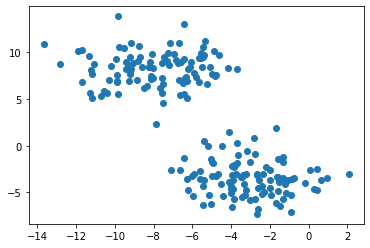

In [2]:
n = 200
np.random.seed(1111)
X, y = datasets.make_blobs(n_samples=n, shuffle=True, random_state=None, centers = 2, cluster_std = 2.0)
plt.scatter(X[:,0], X[:,1])

*Clustering* refers to the task of separating this data set into the two natural "blobs." K-means is a very common way to achieve this task, which has good performance on circular-ish blobs like these: 

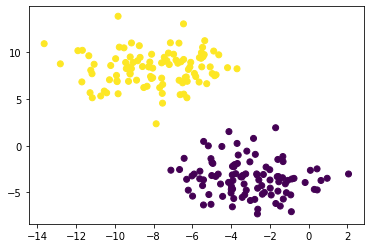

In [3]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 2)
km.fit(X)

plt.scatter(X[:,0], X[:,1], c = km.predict(X))

### Harder Clustering

That was all well and good, but what if our data is "shaped weird"? 

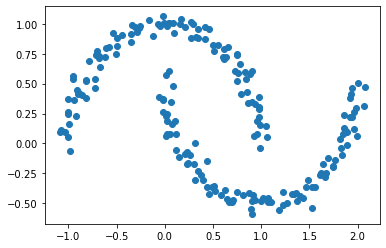

In [4]:
np.random.seed(1234)
n = 200
X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=0.05, random_state=None)
plt.scatter(X[:,0], X[:,1])

We can still make out two meaningful clusters in the data, but now they aren't blobs but crescents. As before, the Euclidean coordinates of the data points are contained in the matrix `X`, while the labels of each point are contained in `y`. Now k-means won't work so well, because k-means is, by design, looking for circular clusters. 

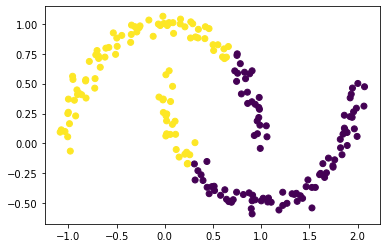

In [5]:
km = KMeans(n_clusters = 2)
km.fit(X)
plt.scatter(X[:,0], X[:,1], c = km.predict(X))

Whoops! That's not right! 

As we'll see, spectral clustering is able to correctly cluster the two crescents. In the following problems, you will derive and implement spectral clustering. 

## Part A

Construct the *similarity matrix* $\mathbf{A}$. $\mathbf{A}$ should be a matrix (2d `np.ndarray`) with shape `(n, n)` (recall that `n` is the number of data points). 

When constructing the similarity matrix, use a parameter `epsilon`. Entry `A[i,j]` should be equal to `1` if `X[i]` (the coordinates of data point `i`) is within distance `epsilon` of `X[j]` (the coordinates of data point `j`), and `0` otherwise. 

**The diagonal entries `A[i,i]` should all be equal to zero.** The function `np.fill_diagonal()` is a good way to set the values of the diagonal of a matrix.  

#### Note

It is possible to do this manually in a `for`-loop, by testing whether `(X[i] - X[j])**2 < epsilon**2` for each choice of `i` and `j`. This is not recommended! Instead, see if you can find a solution built into `sklearn`. Can you find a function that will compute all the pairwise distances and collect them into an appropriate matrix for you? 

For this part, use `epsilon = 0.4`. 

## Part B

The matrix `A` now contains information about which points are near (within distance `epsilon`) which other points. We now pose the task of clustering the data points in `X` as the task of partitioning the rows and columns of `A`. 

Let $d_i = \sum_{j = 1}^n a_{ij}$ be the $i$th row-sum of $\mathbf{A}$, which is also called the *degree* of $i$. Let $C_0$ and $C_1$ be two clusters of the data points. We assume that every data point is in either $C_0$ or $C_1$. The cluster membership as being specified by `y`. We think of `y[i]` as being the label of point `i`. So, if `y[i] = 1`, then point `i` (and therefore row $i$ of $\mathbf{A}$) is an element of cluster $C_1$.  

The *binary norm cut objective* of a matrix $\mathbf{A}$ is the function 

$$N_{\mathbf{A}}(C_0, C_1)\equiv \mathbf{cut}(C_0, C_1)\left(\frac{1}{\mathbf{vol}(C_0)} + \frac{1}{\mathbf{vol}(C_1)}\right)\;.$$

In this expression, 
- $\mathbf{cut}(C_0, C_1) \equiv \sum_{i \in C_0, j \in C_1} a_{ij}$ is the *cut* of the clusters $C_0$ and $C_1$. 
- $\mathbf{vol}(C_0) \equiv \sum_{i \in C_0}d_i$, where $d_i = \sum_{j = 1}^n a_{ij}$ is the *degree* of row $i$ (the total number of all other rows related to row $i$ through $A$). The *volume* of cluster $C_0$ is a measure of the size of the cluster. 

A pair of clusters $C_0$ and $C_1$ is considered to be a "good" partition of the data when $N_{\mathbf{A}}(C_0, C_1)$ is small. To see why, let's look at each of the two factors in this objective function separately. 


#### B.1 The Cut Term

First, the cut term $\mathbf{cut}(C_0, C_1)$ is the number of nonzero entries in $\mathbf{A}$ that relate points in cluster $C_0$ to points in cluster $C_1$. Saying that this term should be small is the same as saying that points in $C_0$ shouldn't usually be very close to points in $C_1$. 

Write a function called `cut(A,y)` to compute the cut term. You can compute it by summing up the entries `A[i,j]` for each pair of points `(i,j)` in different clusters. 

There is a solution for computing the cut term that uses only `numpy` tools and no loops. However, it's fine to use `for`-loops for this part only -- we're going to see a more efficient approach later. 

Compute the cut objective for the true clusters `y`. Then, generate a random vector of random labels of length `n`, with each label equal to either 0 or 1. Check the cut objective for the random labels. You should find that the cut objective for the true labels is *much* smaller than the cut objective for the random labels. 

This shows that this part of the cut objective indeed favors the true clusters over the random ones. 

#### B.2 The Volume Term 

Now take a look at the second factor in the norm cut objective. This is the *volume term*. As mentioned above, the *volume* of cluster $C_0$ is a measure of how "big" cluster $C_0$ is. If we choose cluster $C_0$ to be small, then $\mathbf{vol}(C_0)$ will be small and $\frac{1}{\mathbf{vol}(C_0)}$ will be large, leading to an undesirable higher objective value. 

Synthesizing, the binary normcut objective asks us to find clusters $C_0$ and $C_1$ such that:

1. There are relatively few entries of $\mathbf{A}$ that join $C_0$ and $C_1$. 
2. Neither $C_0$ and $C_1$ are too small. 

Write a function called `vols(A,y)` which computes the volumes of $C_0$ and $C_1$, returning them as a tuple. For example, `v0, v1 = vols(A,y)` should result in `v0` holding the volume of cluster `0` and `v1` holding the volume of cluster `1`. Then, write a function called `normcut(A,y)` which uses `cut(A,y)` and `vols(A,y)` to compute the binary normalized cut objective of a matrix `A` with clustering vector `y`. 

***Note***: No for-loops in this part. Each of these functions should be implemented in five lines or less. 

Now, compare the `normcut` objective using both the true labels `y` and the fake labels you generated above. What do you observe about the normcut for the true labels when compared to the normcut for the fake labels? 

## Part C

We have now defined a normalized cut objective which takes small values when the input clusters are (a) joined by relatively few entries in $A$ and (b) not too small. One approach to clustering is to try to find a cluster vector `y` such that `normcut(A,y)` is small. However, this is an NP-hard combinatorial optimization problem, which means that may not be possible to find the best clustering in practical time, even for relatively small data sets. We need a math trick! 

Here's the trick: define a new vector $\mathbf{z} \in \mathbb{R}^n$ such that: 

$$
z_i = 
\begin{cases}
    \frac{1}{\mathbf{vol}(C_0)} &\quad \text{if } y_i = 0 \\ 
    -\frac{1}{\mathbf{vol}(C_1)} &\quad \text{if } y_i = 1 \\ 
\end{cases}
$$


Note that the signs of  the elements of $\mathbf{z}$ contain all the information from $\mathbf{y}$: if $i$ is in cluster $C_0$, then $y_i = 0$ and $z_i > 0$. 

Next, if you like linear algebra, you can show that 

$$\mathbf{N}_{\mathbf{A}}(C_0, C_1) = 2\frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}}\;,$$

where $\mathbf{D}$ is the diagonal matrix with nonzero entries $d_{ii} = d_i$, and  where $d_i = \sum_{j = 1}^n a_i$ is the degree (row-sum) from before.  

1. Write a function called `transform(A,y)` to compute the appropriate $\mathbf{z}$ vector given `A` and `y`, using the formula above. 
2. Then, check the equation above that relates the matrix product to the normcut objective, by computing each side separately and checking that they are equal. 
3. While you're here, also check the identity $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$, where $\mathbb{1}$ is the vector of `n` ones (i.e. `np.ones(n)`). This identity effectively says that $\mathbf{z}$ should contain roughly as many positive as negative entries. 

#### Programming Note

You can compute $\mathbf{z}^T\mathbf{D}\mathbf{z}$ as `z@D@z`, provided that you have constructed these objects correctly. 

#### Note

The equation above is exact, but computer arithmetic is not! `np.isclose(a,b)` is a good way to check if `a` is "close" to `b`, in the sense that they differ by less than the smallest amount that the computer is (by default) able to quantify. 

Also, still no for-loops. 

## Part D

In the last part, we saw that the problem of minimizing the normcut objective is mathematically related to the problem of minimizing the function 

$$ R_\mathbf{A}(\mathbf{z})\equiv \frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}} $$

subject to the condition $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$. It's actually possible to bake this condition into the optimization, by substituting for $\mathbf{z}$ the orthogonal complement of $\mathbf{z}$ relative to $\mathbf{D}\mathbf{1}$. In the code below, I define an `orth_obj` function which handles this for you. 

Use the `minimize` function from `scipy.optimize` to minimize the function `orth_obj` with respect to $\mathbf{z}$. Note that this computation might take a little while. Explicit optimization can be pretty slow! Give the minimizing vector a name `z_`. 

In [ ]:
def orth(u, v):
    return (u @ v) / (v @ v) * v

e = np.ones(n) 

d = D @ e

def orth_obj(z):
    z_o = z - orth(z, d)
    return (z_o @ (D - A) @ z_o)/(z_o @ D @ z_o)

**Note**: there's a cheat going on here! We originally specified that the entries of $\mathbf{z}$ should take only one of two values (back in Part C), whereas now we're allowing the entries to have *any* value! This means that we are no longer exactly optimizing the normcut objective, but rather an approximation. This cheat is so common that deserves a name: it is called the *continuous relaxation* of the normcut problem. 

## Part E

Recall that, by design, only the sign of `z_min[i]` actually contains information about the cluster label of data point `i`. Plot the original data, using one color for points such that `z_min[i] < 0` and another color for points such that `z_min[i] >= 0`. 

Does it look like we came close to correctly clustering the data? 

## Part F

Explicitly optimizing the orthogonal objective is  *way* too slow to be practical. If spectral clustering required that we do this each time, no one would use it. 

The reason that spectral clustering actually matters, and indeed the reason that spectral clustering is called *spectral* clustering, is that we can actually solve the problem from Part E using eigenvalues and eigenvectors of matrices. 

Recall that what we would like to do is minimize the function 

$$ R_\mathbf{A}(\mathbf{z})\equiv \frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}} $$

with respect to $\mathbf{z}$, subject to the condition $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$. 

The Rayleigh-Ritz Theorem states that the minimizing $\mathbf{z}$ must be the solution with smallest eigenvalue of the generalized eigenvalue problem 

$$ (\mathbf{D} - \mathbf{A}) \mathbf{z} = \lambda \mathbf{D}\mathbf{z}\;, \quad \mathbf{z}^T\mathbf{D}\mathbb{1} = 0$$

which is equivalent to the standard eigenvalue problem 

$$ \mathbf{D}^{-1}(\mathbf{D} - \mathbf{A}) \mathbf{z} = \lambda \mathbf{z}\;, \quad \mathbf{z}^T\mathbb{1} = 0\;.$$

Why is this helpful? Well, $\mathbb{1}$ is actually the eigenvector with smallest eigenvalue of the matrix $\mathbf{D}^{-1}(\mathbf{D} - \mathbf{A})$. 

> So, the vector $\mathbf{z}$ that we want must be the eigenvector with  the *second*-smallest eigenvalue. 

Construct the matrix $\mathbf{L} = \mathbf{D}^{-1}(\mathbf{D} - \mathbf{A})$, which is often called the (normalized) *Laplacian* matrix of the similarity matrix $\mathbf{A}$. Find the eigenvector corresponding to its second-smallest eigenvalue, and call it `z_eig`. Then, plot the data again, using the sign of `z_eig` as the color. How did we do? 

In fact, `z_eig` should be proportional to `z_min`, although this won't be exact because minimization has limited precision by default. 

## Part G

Synthesize your results from the previous parts. In particular, write a function called `spectral_clustering(X, epsilon)` which takes in the input data `X` (in the same format as Part A) and the distance threshold `epsilon` and performs spectral clustering, returning an array of binary labels indicating whether data point `i` is in group `0` or group `1`. Demonstrate your function using the supplied data from the beginning of the problem. 

#### Notes

Despite the fact that this has been a long journey, the final function should be quite short. You should definitely aim to keep your solution under 10, very compact lines. 

**In this part only, please supply an informative docstring!** 

#### Outline

Given data, you need to: 

1. Construct the similarity matrix. 
2. Construct the Laplacian matrix. 
3. Compute the eigenvector with second-smallest eigenvalue of the Laplacian matrix. 
4. Return labels based on this eigenvector. 

## Part H

Run a few experiments using your function, by generating different data sets using `make_moons`. What happens when you increase the `noise`? Does spectral clustering still find the two half-moon clusters? For these experiments, you may find it useful to increase `n` to `1000` or so -- we can do this now, because of our fast algorithm! 

## Part I

Now try your spectral clustering function on another data set -- the bull's eye! 

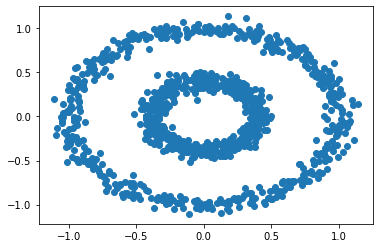

In [6]:
n = 1000
X, y = datasets.make_circles(n_samples=n, shuffle=True, noise=0.05, random_state=None, factor = 0.4)
plt.scatter(X[:,0], X[:,1])

There are two concentric circles. As before k-means will not do well here at all. 

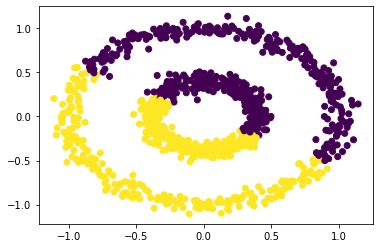

In [7]:
km = KMeans(n_clusters = 2)
km.fit(X)
plt.scatter(X[:,0], X[:,1], c = km.predict(X))

Can your function successfully separate the two circles? Some experimentation here with the value of `epsilon` is likely to be required. Try values of `epsilon` between `0` and `1.0` and describe your findings. For roughly what values of `epsilon` are you able to correctly separate the two rings? 

## Part J

Great work! Turn this notebook into a blog post with plenty of helpful explanation for your reader. Remember that your blog post should be entirely in your own words, without any copying and pasting from this notebook. Remember also that extreme mathematical detail is not required. 